### Mlp-Mixer

In [17]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from functools import partial
from einops.layers.torch import Rearrange, Reduce
import matplotlib.pyplot as plt
import numpy as np

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from einops.layers.torch import Rearrange, Reduce

# 定义 MlpMixer 模型
class MlpBlock(nn.Module):
    def __init__(self, dim, mlp_dim, dropout=0.):
        super(MlpBlock, self).__init__()
        self.fc1 = nn.Linear(dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class MixerLayer(nn.Module):
    def __init__(self, num_patches, hidden_dim, token_mlp_dim, channel_mlp_dim, dropout=0.):
        super(MixerLayer, self).__init__()
        self.token_mixing = nn.Sequential(
            nn.LayerNorm(num_patches),
            nn.Linear(num_patches, token_mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(token_mlp_dim, num_patches),
            nn.Dropout(dropout)
        )
        self.channel_mixing = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, channel_mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(channel_mlp_dim, hidden_dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Token mixing
        y = x.permute(0, 2, 1)
        y = self.token_mixing(y)
        y = y.permute(0, 2, 1)
        x = x + y
        # Channel mixing
        y = self.channel_mixing(x)
        x = x + y
        return x

class MlpMixer(nn.Module):
    def __init__(self, image_size, patch_size, hidden_dim, num_layers, num_classes, token_mlp_dim, channel_mlp_dim, dropout=0.):
        super(MlpMixer, self).__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        
        self.patch_embedding = nn.Conv2d(1, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.mixer_layers = nn.ModuleList([
            MixerLayer(num_patches, hidden_dim, token_mlp_dim, channel_mlp_dim, dropout) for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embedding(x).flatten(2).permute(0, 2, 1)  # [batch_size, num_patches, hidden_dim]
        for layer in self.mixer_layers:
            x = layer(x)
        x = self.layer_norm(x)  # Apply LayerNorm on the last dimension
        x = x.mean(dim=1)  # Global average pooling
        return self.fc(x)


# 超参数设置
image_size = 28
patch_size = 4
hidden_dim = 128
num_layers = 2
num_classes = 10
token_mlp_dim = 256
channel_mlp_dim = 512
dropout = 0.2
batch_size = 32
epochs = 10

# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 数据加载
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = datasets.MNIST('./data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

# 模型初始化
model = MlpMixer(image_size, patch_size, hidden_dim, num_layers, num_classes, token_mlp_dim, channel_mlp_dim, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

print(model)

MlpMixer(
  (patch_embedding): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
  (mixer_layers): ModuleList(
    (0): MixerLayer(
      (token_mixing): Sequential(
        (0): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=49, out_features=256, bias=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.2, inplace=False)
        (4): Linear(in_features=256, out_features=49, bias=True)
        (5): Dropout(p=0.2, inplace=False)
      )
      (channel_mixing): Sequential(
        (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=128, out_features=512, bias=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0.2, inplace=False)
        (4): Linear(in_features=512, out_features=128, bias=True)
        (5): Dropout(p=0.2, inplace=False)
      )
    )
    (1): MixerLayer(
      (token_mixing): Sequential(
        (0): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
        (1):

## Learning

Let's now define functions to `train()` and `validate()` the model. 

In [19]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        # Copy data to GPU if needed
        data = data.to(device)
        target = target.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()  
        
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))


def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in validation_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))


# 训练模型
lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.602157
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.583576
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.415777
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.303204
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.261712
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.350055
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.471823
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.338169
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.326729
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.386198

Validation set: Average loss: 0.2579, Accuracy: 9248/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.129316
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.430219
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.454098
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.564860
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.296314
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.121340
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.509325
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.211921
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.25

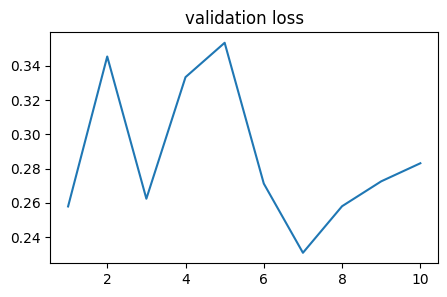

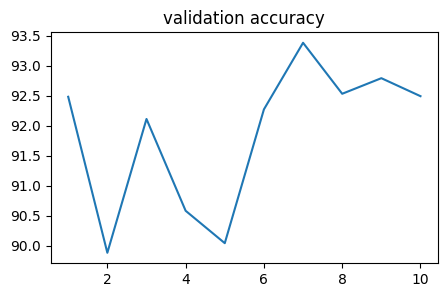

In [20]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');